In [6]:
import sys
sys.version

'3.8.2 | packaged by conda-forge | (default, Mar 23 2020, 17:55:48) \n[Clang 9.0.1 ]'

# Performance Validation
[Performance of Pandas apply vs np.vectorize to create new column from existing columns](https://stackoverflow.com/questions/52673285/performance-of-pandas-apply-vs-np-vectorize-to-create-new-column-from-existing-c/52674448#52674448)


## An Example

In [25]:
import pandas as pd
import geopandas
import geopy.distance
from math import radians, cos, sin, asin, sqrt
# geopy.distance.distance()

In [33]:
city1 = [{'City':"Buenos Aires","Country":"Argentina","Latitude":-34.58,"Longitude":-58.66},
           {'City':"Brasilia","Country":"Brazil","Latitude":-15.78 ,"Longitude":-70.66},
         {'City':"Santiago","Country":"Chile ","Latitude":-33.45 ,"Longitude":-70.66 }]
city2 =  [{'City':"Bogota","Country":"Colombia ","Latitude":4.60 ,"Longitude":-74.08},
           {'City':"Caracas","Country":"Venezuela","Latitude":10.48  ,"Longitude":-66.86}]
city1df = pd.DataFrame(city1)
city2df = pd.DataFrame(city2)

In [26]:
def dist1(p1, p2):
    lon1, lat1, lon2, lat2 = map(radians, [p1.x, p1.y, p2.x, p2.y])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    return c * 6373

def dist2(p1, p2):
    lon1, lat1, lon2, lat2 = map(radians, [p1[0], p1[1], p2[0], p2[1]])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    return c * 6373

def dist3(p1, p2):
    x = p1.y, p1.x
    y = p2.y, p2.x

    return geopy.distance.geodesic(x, y).km

def dist4(p1, p2):
    x = p1[1], p1[0]
    y = p2[1], p2[0]

    return geopy.distance.geodesic(x, y).km

In [34]:
gcity1df = geopandas.GeoDataFrame(
    city1df, 
    geometry=geopandas.points_from_xy(city1df.Longitude, city1df.Latitude)
)
gcity2df = geopandas.GeoDataFrame(
    city2df, 
    geometry=geopandas.points_from_xy(city2df.Longitude, city2df.Latitude)
)

# cross join geopandas
gcity1df['key'] = 1
gcity2df['key'] = 1
merged = gcity1df.merge(gcity2df, on='key')

In [40]:
merged['dist'] = list(map(dist1, merged['geometry_x'], merged['geometry_y']))
mapping = {
    'City_x': 'City',
    'Country_x': 'Country',
    'Latitude_x': 'Latitude',
    'Longitude_x': 'Longitude',
    'geometry_x': 'geometry',
    'City_y': 'Nearest',
    'dist': 'Distance'
}

nearest = merged.loc[merged.groupby(['City_x', 'Country_x'])['dist'].idxmin()]
nearest.rename(columns=mapping)[list(mapping.values())]

,City,Country,Latitude,Longitude,geometry,Nearest,Distance
2,Brasilia,Brazil,-15.78,-70.66,POINT (-70.66000 -15.78000),Bogota,2297.922808
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000),Bogota,4648.004515
4,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000),Bogota,4247.586882


## Comparision

In [49]:
import warnings
import math
warnings.filterwarnings("ignore")

def index_where(num_a,min_a,step_s):
    num_b = math.ceil((num_a-min_a)/step_s)
    return str(num_b)

In [51]:
df = pd.read_csv("/Users/soda/Downloads/CodingFile/RAI_工程代码/che300/data_finall.csv",encoding='gbk')
df.columns = ['device_imei', 'gps_time', 'longitude', 'latitude', 'carid', 'date']
df.head(2)

,device_imei,gps_time,longitude,latitude,carid,date
0,862368010117495,2019-10-01 07:52:02.962,112.036533,22.933911,粤WRM007,2019-10-01
1,862368010117495,2019-10-01 07:52:13.937,112.036898,22.933698,粤WRM007,2019-10-01


In [52]:
lat_min = df['latitude'].min()
lat_step = 0.0001

In [63]:
%timeit df['loc_lat'] = df['latitude'].apply(lambda x:index_where(x,lat_min,lat_step))

380 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
def index_where(num_a,min_a=lat_min,step_s=lat_step):
    num_b = math.ceil((num_a-min_a)/step_s)
    return str(num_b)

In [64]:
%timeit df['loc_lat'] = list(map(index_where,df['latitude']))

339 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Spatial Queries
[r-tree spatial indexing with Python and geopandas](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/)

In [65]:
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

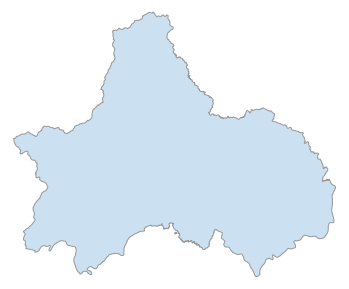

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12af20430>)

In [128]:
city = ox.gdf_from_place("成都市,中国",which_result=2)
ox.plot_shape(ox.project_gdf(city))

In [129]:
gdf = ox.gdf_from_place('Walnut Creek, California, USA')
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-122.10015 37.91741, -122.09996 37.9...","Walnut Creek, Contra Costa County, California,...",37.946337,37.842468,-121.980607,-122.100149


In [134]:
west, south, east, north = gdf.unary_union.buffer(0.1).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)

In [135]:
# get lat-long points for each intersection
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))

In [136]:
# turn the lat-long points into a geodataframe
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)

In [137]:
# make the geometry a multipolygon if it's not already
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

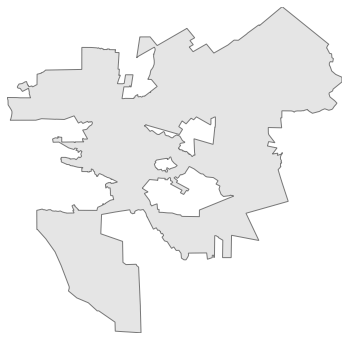

In [138]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

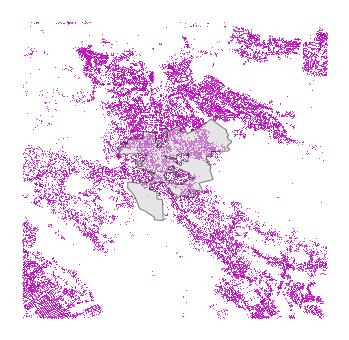

In [141]:
# plot the intersections and the city
# west, south, east, north = gdf_nodes.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [142]:
sindex = gdf_nodes.sindex
possible_matches_index = list(sindex.intersection(geometry.bounds))
possible_matches = gdf_nodes.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(geometry)]

In [143]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

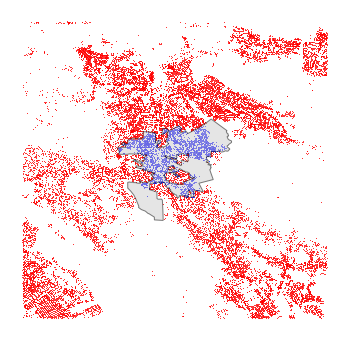

In [144]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)
ax.axis('off')
plt.show()


# `Install Instruction`

`install on Virtual Enviroment`

```bash
conda create -n geo_env
# /Users/soda/anaconda3/envs/geo_env
source deactivate
conda activate geo_env
conda config --env --add channels conda-forge
conda config --env --set channel_priority strict
conda install python=3 geopandas
conda install python=3 osmnx
conda install ipykernel
sudo python -m ipykernel install --user --name=geo_env
jupyter notebook
```
1. https://geopandas.readthedocs.io/en/latest/install.html
2. https://osmnx.readthedocs.io/en/stable/#installation
3. https://github.com/geopandas/geopandas/issues/1109
4. https://blog.csdn.net/qq_18298439/article/details/96278997
5. http://www.doc88.com/p-9902138592893.html
6. https://github.com/Anaconda-Platform/nb_conda_kernels
7. http://blog.itpub.net/69945560/viewspace-2669072/
8. https://geoffboeing.com/publications/osmnx-complex-street-networks/

In [15]:
import numpy as np
import pandas as pd
data = pd.read_excel("/Users/soda/Downloads/CodingFile/hotel/chengdu.xlsx")

In [16]:
data.head(2)

,name,address,price,score,recommendation,num_comments,lat,lng
0,成都城市名人酒店,【 天府广场、盐市口商业区 春熙路、太古里商业区】青羊区人民南路一段122-124号，近陕西...,648,4.8,98%,12923.0,30.656593,104.063043
1,成都索菲斯锦苑宾馆,【 文殊院、人民北路商业区 太升路、四川电视塔】青羊区人民中路三段22号，近1号线文殊院站K...,484,4.9,99%,17083.0,30.679346,104.068263
